In [459]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io

from utils import * 

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")

In [460]:
## Get OPC data
def get_drone_opc(dfile):
    opc = pd.read_csv(dfile, skiprows=4,sep=',',error_bad_lines=False) 
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    #opc = opc[~opc.index.duplicated()]
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667

    # Get total counts
    opc['total_counts']=opc['b0'].astype(float)+ opc['b1'].astype(float)+ opc['b2'].astype(float)+ opc['b3'].astype(float)+ opc['b4'].astype(float)+ opc['b5'].astype(float)+ opc['b6'].astype(float)+ opc['b7'].astype(float)+ opc['b8'].astype(float)+ opc['b9'].astype(float)+ opc['b10'].astype(float)+ opc['b11'].astype(float)+ opc['b12'].astype(float)+ opc['b13'].astype(float)+ opc['b14'].astype(float)+ opc['b15'].astype(float)+ opc['b16'].astype(float)+ opc['b17'].astype(float)+ opc['b18'].astype(float)+ opc['b19'].astype(float)+ opc['b20'].astype(float)+ opc['b21'].astype(float)+ opc['b22'].astype(float)+ opc['b23'].astype(float)
    opc['total_counts']=opc['total_counts'].replace({0: np.nan})
    # Convert total counts/interval to total counts/s
    opc.period = opc.period/100 # period in s
    opc.total_counts = opc.total_counts /opc.period
    # Convert total counts/second to counts/cm3
    opc['OPC_conc'] = opc.total_counts / opc.FlowRate

    return opc

In [461]:
# Split profiles 1 - 4
def split_profiles(df):
    df['P_diff']=df['P'].diff(periods=20)
    df['P_dd']=df['P_diff'].diff(periods=20).abs()
    inflections = df[df['P_dd']<0.3].index
    ilist=[]
    for i in range(1,len(inflections)):
        if inflections[i]-inflections[i-1] > dt.timedelta(seconds=20):
            ilist.append(inflections[i])

    df['RowN'] = np.arange(len(df))
    l = list(df['RowN'].ix[ilist])
    l_mod = [0] + l + [max(df['RowN'])]
    list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
    return list_of_dfs

In [462]:
# Find start and end times
def get_start_end(list_of_dfs):
    start = list_of_dfs[0]
    c=1
    while max(start.P)-min(start.P)<5:
        start = list_of_dfs[c]
        c=c+1
    
    start_time = start.index[0]

    end = list_of_dfs[-1]
    c=len(list_of_dfs)-1
    while max(end.P)-min(end.P)<5:
        end = list_of_dfs[c]
        c=c-1
    
    end_time = end.index[-1]
    return start_time,end_time

In [465]:
# Find MSF OPC data
def get_MSF(MSF_dloc,start_time):
    dfile = 'Summit_MSF_ICECAPSACE_OPCN3_N1_%s.csv'%dt.datetime.strftime(start_time,'%Y-%m-%d')
    try:
        MSF_df = get_drone_opc(MSF_dloc+dfile)
        MSF_concs = MSF_df['OPC_conc'].between_time(str(start_time.time()),str(end_time.time()))
        MSF_concs.dropna(inplace=True)
        max_msf = max(MSF_concs)
        min_msf = min(MSF_concs)
        mean_msf = MSF_concs.mean()
    except IOError:
        print('Cant find MSF OPC file for %s'%start_time)
        return
    return max_msf,min_msf,mean_msf

In [485]:
# Plot profiles
def plot_profile(list_of_dfs,min_msf,mean_msf,max_msf,start_time,d_loc):
    fig = plt.figure(figsize=(5,7))
    ax = fig.add_subplot(111)
    for i in range(0,len(list_of_dfs)):
        d=list_of_dfs[i]
        if max(d.P)-min(d.P)>5:
            ax.semilogx(d.OPC_conc,d.P,label=str(d.index[0].time()),alpha=0.8)
            maxP= max(d.P)
            minP= min(d.P)
        
    ax.scatter([min_msf,mean_msf,max_msf],[maxP-0.4,maxP-0.4,maxP-0.4],marker='X',c='m',label='MSF OPC during flight\n(min,mean,max)')
    ax.grid(True)
    ax.set_ylim(maxP,minP)
    ax.set_xlim(0.001,10)
    ax.set_ylabel('Pressure (hPa)')
    ax.set_title('Drone profile: \n%s'%str(start_time))
    ax.set_xlabel('Total aerosol concentration (cc)')
    ax.legend(loc='best',fontsize=9)
    fig.tight_layout()
    fig.savefig(d_loc + 'Drone_profile_%s.png'%str(start_time))


        

No profile found for 2019-06-23
No profile found for 2019-06-22
No profile found for 2019-06-23
No profile found for 2019-06-24
No profile found for 2019-06-23
No profile found for 2019-06-23
No profile found for 2019-06-23


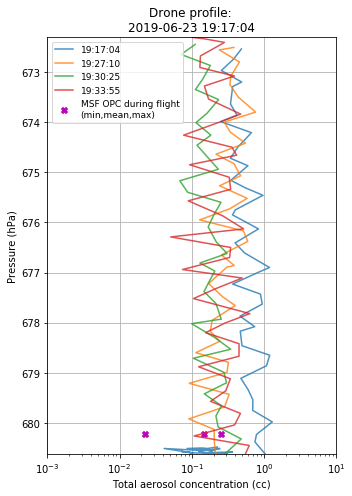

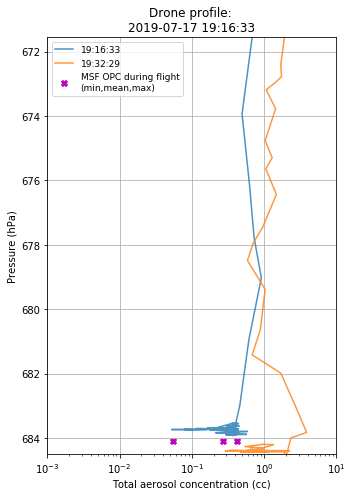

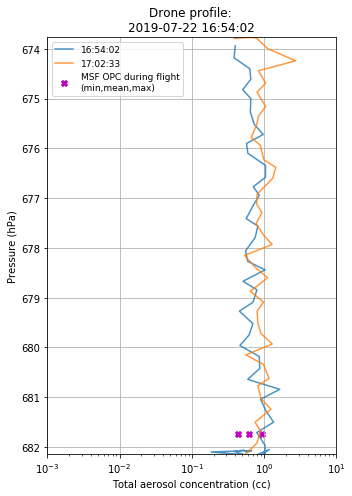

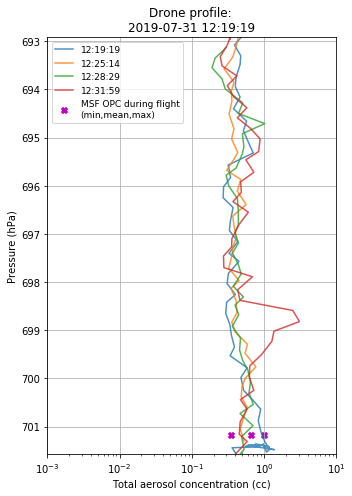

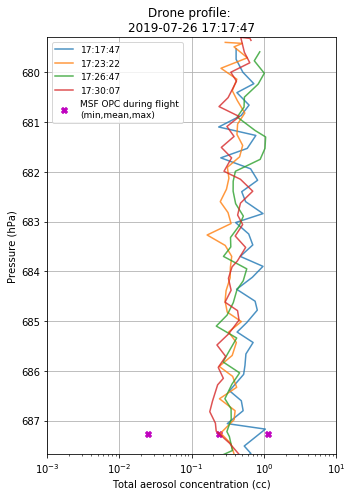

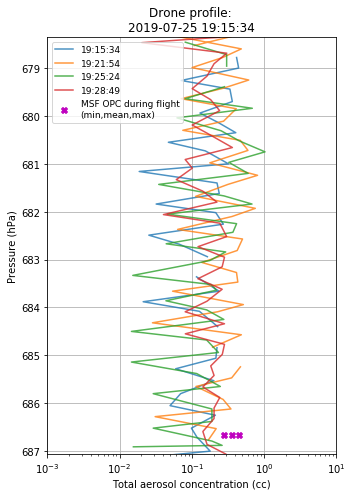

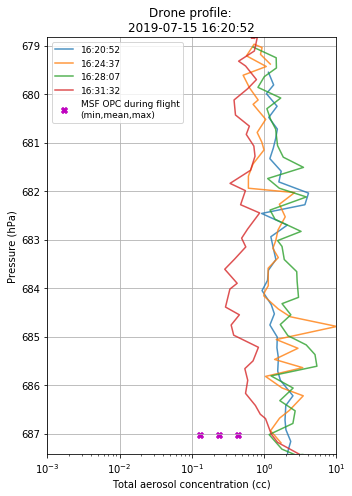

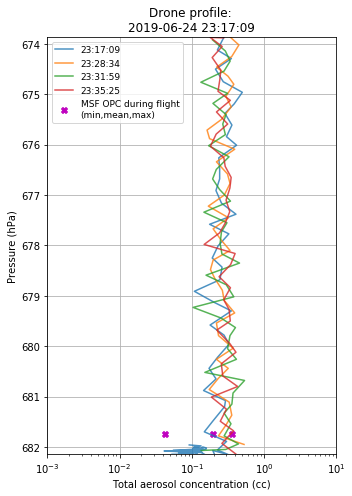

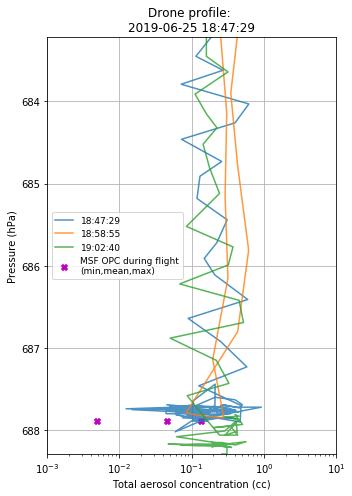

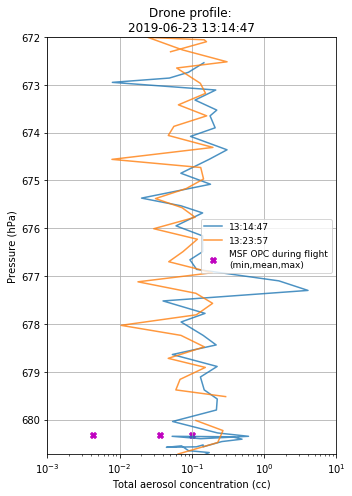

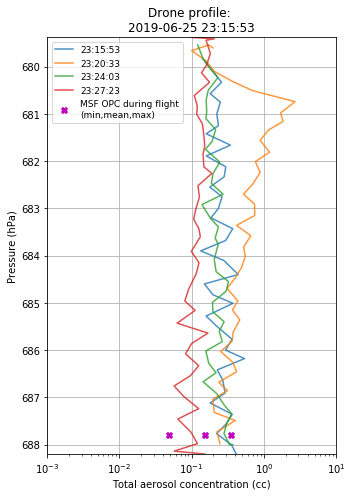

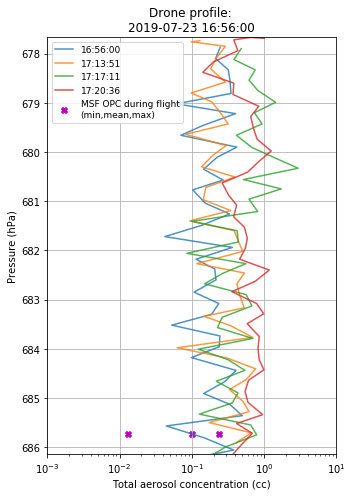

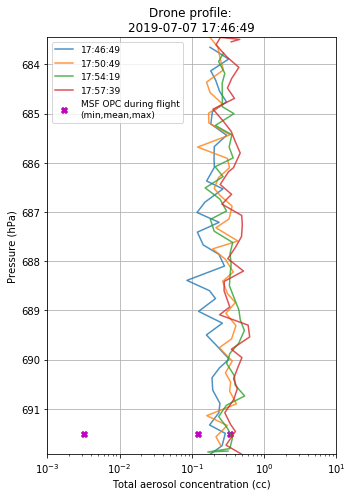

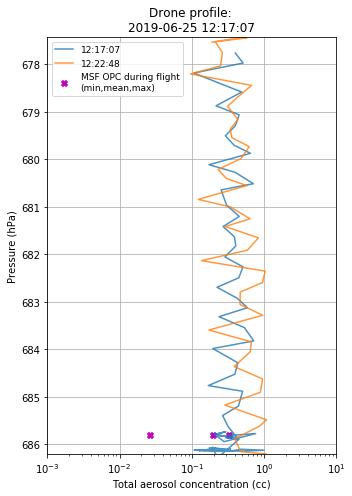

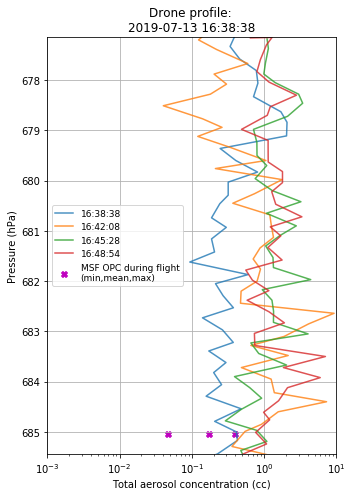

In [486]:
# Get profile dates:
d_loc='/Users/heather/ICECAPS-ACE/Data/Drone_flights/'
MSF_dloc = '/Users/heather/Desktop/aerosol_quicklooks/Data/'
os.chdir(d_loc)                 # Change directory to where the data is
all_kml = glob.glob('*.kml')
all_dates = np.asarray([(dt.datetime.strptime(f.split()[1]+f.split()[2]+f.split()[3],'%m_%d_%Y%I_%M_%S%p')) for f in all_kml])

# Get opc profile files from date
fnames=[]
for i in range(0,len(all_dates)):
    date = all_dates[i]
    fname = glob.glob('SummitGreenland_ICECAPS-ACE_Drone_OPCN3_N3_%s*.csv'%(dt.datetime.strftime(date,'%Y%m%d%H')))
    if len(fname)==0:
        fname = glob.glob('SummitGreenland_ICECAPS-ACE_Drone_OPCN3_N3_%s*.csv'%(dt.datetime.strftime(date-dt.timedelta(hours=1),'%Y%m%d%H')))
        if len(fname)==0:
            print('No profile found for %s'%date.date())
            continue
        
    if len(fname)<1:
        print('Multiple profiles found for %s, using first'%date.date())
        fname=fname[0]

    fnames.append(fname)

for fname in fnames:
    df = get_drone_opc(d_loc+fname[0])
    list_of_dfs = split_profiles(df)
    try:
        start_time,end_time = get_start_end(list_of_dfs)
        max_msf,min_msf,mean_msf = get_MSF(MSF_dloc,start_time)
        plot_profile(list_of_dfs,min_msf,mean_msf,max_msf,start_time,d_loc)
    except:
        pass